# Applying Complex Orthogonal Decomposition to Lampreys swimming in fluid environment of various viscosity
# Part II - Initial COD analysis
## In this notebook, we perform initial COD analysis to take a look at traveling indices and complex orthogonal values
### Author: Yuexia Luna Lin (luna.lin@epfl.ch)
### Data provided by Prof. Eric Tytell.

# Start by loading some necessary libraries and our pre-processed dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import zipfile

import os
from os import listdir
from os.path import isfile, isdir, join
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.fft import rfft, irfft
from scipy.linalg import eigh
from scipy.optimize import curve_fit, brute, minimize

# The following two lines is to be able toeasily convert
# comma decimal place to point decimal place
import locale
locale.setlocale(locale.LC_NUMERIC, "fr_CH.ISO8859-15")
import time

# To read Eric's h5 file, we can't use Pandas since it requires a particular structure within the HDF5 file.
# So we need this library
import h5py

#%matplotlib inline
%matplotlib notebook

# Read in the pre-processed dataset

In [5]:
# We read in the pre-processed dataset
data_frame = pd.read_hdf("../Data/processed_midline_all.h5")

In [6]:
data_frame.head(30)

,filename,date,indiv,trial,t,frame,point,mxmm,mymm,viscosity,...,bodyaxisy,bodycoordx,bodycoordy,swimvelx,swimvely,swimvel,theta,d_theta,com_vel_theta,com_vel_d_theta
0,1,15868,1,1,0.58,0,1,341.299771,88.110667,1,...,-0.311522,73.796770,-7.270154,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
1,1,15868,1,1,0.58,0,2,349.324554,90.105424,1,...,-0.311522,65.549898,-6.665755,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
2,1,15868,1,1,0.58,0,3,357.545449,91.064575,1,...,-0.311522,57.439287,-5.016190,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
3,1,15868,1,1,0.58,0,4,365.759349,91.948042,1,...,-0.311522,49.358900,-3.296886,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
4,1,15868,1,1,0.58,0,5,374.046024,91.781670,1,...,-0.311522,41.536407,-0.557311,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
5,1,15868,1,1,0.58,0,6,382.245394,90.914370,1,...,-0.311522,34.015228,2.821113,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
6,1,15868,1,1,0.58,0,7,390.329370,89.114436,1,...,-0.311522,26.894238,7.049815,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
7,1,15868,1,1,0.58,0,8,398.584686,88.492048,1,...,-0.311522,19.243602,10.212945,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
8,1,15868,1,1,0.58,0,9,406.743469,89.811668,1,...,-0.311522,11.079718,11.500629,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
9,1,15868,1,1,0.58,0,10,414.012944,93.737974,1,...,-0.311522,2.948849,10.034300,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216


# We define two functions to extract body position data 
- (x, y) in the lab frame
- (x, y) in the body frame (body aligned with $x$-axis)

## We can then visualize the raw data: in the lab frame or in body frame.

In [7]:
def extract_single_trial_bodyframe(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the frame where COM is at the origin, and the body axis align with x axis.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    # For each body part, average the bodycoordinate (this only works)
    # if we have projected to bodyframe and fixed the origin at COM
    xdata = np.array([df.loc[df['point'] == i, 'bodycoordx'].mean() for i in bodyparts])
    
    ydata = np.empty([num_frames, len(bodyparts)])
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'bodycoordy'].values
        
    return xdata, ydata

def extract_single_trial(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the lab frame.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    ydata = np.empty([num_frames, num_parts])
    xdata = np.empty_like(ydata)
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'mymm'].values
        xdata[fr] =  df.iloc[start:finish].loc[:,'mxmm'].values
    return xdata, ydata

## Note that "%matplotlib notebook" is needed for animation to show up in the notebook.
## If "%matplotlib inline" has been used before, this may not work anymore in this session. Restart the session, and only issue "%matplotlib notebook" command.

<IPython.core.display.Javascript object>


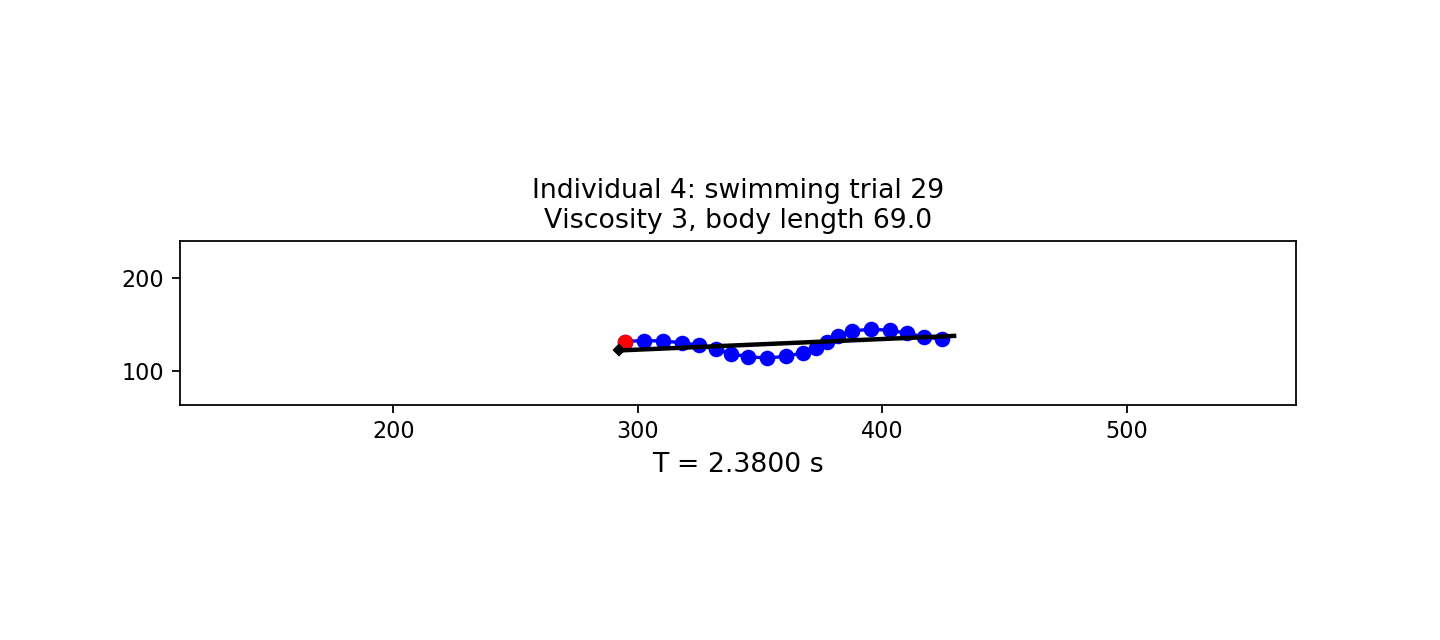

In [14]:
# We test this out on a few trials and see how the fish swim, the heading direction is also drawn on the animation
# Can change values of IND and TRIAL to look at different ones
IND = 4
TRIAL = 29

trial_df = data_frame.loc[ (data_frame['indiv'] == IND) & (data_frame['trial'] == TRIAL) ]
visc = trial_df['viscosity'].unique()[0]
length = trial_df['len'].unique()[0]
start_time = trial_df.iloc[0].loc['t']
length = 0.5 * trial_df['len'].unique()[0]
bodyframe = trial_df.loc[trial_df['point']==1, {'comx', 'comy', 'bodyaxisx', 'bodyaxisy', 'len'}].copy()

xdata, ydata = extract_single_trial(trial_df)

# Animate the swimming fish as a line-point plot
fig, ax = plt.subplots(figsize=(9,4))

ln, = plt.plot([], [], 'bo-')
hd, = plt.plot([], [], 'ro')
br, = plt.plot([], [], 'k-', lw=2)
bd, = plt.plot([], [], 'kD', markersize=3)

def init():
    ymax = np.max(ydata)+40
    ymin = np.min(ydata)-40
    xmin = np.min(xdata)-5
    xmax = np.max(xdata)+5
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect((ymax-ymin)/(xmax-xmin))
    ax.set_title("Individual {}: swimming trial {}\nViscosity {}, body length {:4.1f}"\
                 .format(IND, TRIAL, visc, length))
    return ln,


def update(frame):
    ln.set_data(xdata[frame], ydata[frame])
    #hd.set_data(xdata_interp, ydata_interp[frame])
    hd.set_data(xdata[frame, 0], ydata[frame,0])
    comx = float(bodyframe.iloc[frame]['comx'])
    comy = float(bodyframe.iloc[frame]['comy'])
    bx = length * float(bodyframe.iloc[frame]['bodyaxisx'])
    by = length * float(bodyframe.iloc[frame]['bodyaxisy'])
    br.set_data([comx-bx, comx, comx+bx], [comy-by, comy, comy+by])
    bd.set_data(comx+bx, comy+by)
    
    ax.set_xlabel('T = %.4f s'%(start_time + frame*0.02))
    return ln,

ani = FuncAnimation(fig, update, frames=ydata.shape[0], init_func=init, blit=True);

# # Uncomment this if want to save the animation to file
# # !! I used 'ffmpeg' as my video writer, but on another computer system, it could be different
# ani.save('./labframe_ind{}_trial{}_vis{}.mp4'.format(IND, TRIAL, visc), writer='ffmpeg', fps=50)

# Define the complex orthogonal decomposition functions, and use them to calculate the COD of a given trial, and its traveling indices

In [9]:
# We pass in the real signals
# Organized as: each row represent the whole fish (N body parts) at a time point
def complex_orthog_decomp(real_signal, tf_type=None, dc_type=None):
    """ This function performs COD on real signal, by first complexifying it,
    then decomposing the complex correlation matrix."""
    
    nf = real_signal.shape[0]
    zdata = np.empty_like(real_signal)
    
    if tf_type == None or tf_type == 'FFT':
        # Transform the time series at each sensor location into complex signal
        # See https://en.wikipedia.org/wiki/Analytic_signal
        
        ffty = np.fft.fft(real_signal, axis=0)
        freq = np.fft.fftfreq(nf)
        ffty[freq>0, :] = 2*ffty[freq>0, :]
        ffty[freq<0, :] = 0
        zdata = np.fft.ifft(ffty, axis=0)
        #print(zdata.shape)

    elif tf_type == 'H':

    # According to scipy documentation, hilbert transform output x_a(t) = x(t) + iy(t),
    # which is the complex signal COD calls for (Feeny, 2008)
    # We transform along column direction, axis=0, since each row represents a time point
        zdata = hilbert (real_signal, axis=0)
    
    else: 
        print("Transformation type can either be Fourier Transform (FFT) or Hilbert Transform (H).")
        print("Default is FFT.")
        
    # Cast the ndarray zdata to matrix for convenience
    # The complex ensemble matrix is organized as follows:
    # each row is a time series of signal at a given sensor.
    # In the fish example, in each row we have the time series of a body part
    Z = np.asmatrix(zdata).T

    # Assemble the complex correlation matrix
    R = 1./nf * (Z @ (Z.H))

    #print("Check complex correlation matrix is Hermitian norm(R-R.H): ", np.linalg.norm(R-R.H))
    
    num_samples = real_signal.shape[1]
    U = np.zeros([num_samples, num_samples])
    S = np.zeros(num_samples)
    Vh = np.empty_like(U)
    if dc_type == 'eig':
        # Compute the eigenvalues and eigenvectors of the correlation matrix
        # Using eigen decomposition
        S, U = np.linalg.eigh(R)
        S = np.flip(S)
        U = np.flip(U, axis=1)
        
    elif dc_type == None or dc_type == 'svd':
        # Since R is Hermitian (complex conjugate symmetric)
        # its SVD is just eigen decoposition
        U, S, Vh = np.linalg.svd(R)
        
    else: 
        print("Decomposition type can either be eigen 'eig' or SVD 'svd'.")
        print("Default is SVD.")

        
    return zdata, Z, R, S, U

# Use the real and imaginary part of the eigenmodes to compute traveling index
def traveling_index(U):
    """ This function computes the traveling index for every complex orthogonal mode."""
    
    # The number of traveling indices is the number of modes (columns in eigenvector matrix)
    tr_ind = np.zeros(U.shape[1])

    # For each mode, we create a rectangular matrix with columns being the real and imag part of the mode
    # The traveling index is the inverse of the condition number of this matrix
    for i in range(len(tr_ind)):
        tmp = np.concatenate( (np.real (U[:, i]).reshape(-1,1) , np.imag(U[:, i]).reshape(-1,1)), axis=1)
        cond = np.linalg.cond(tmp)
        tr_ind[i] = 1./cond
        
    return tr_ind

# Compute traveling index for every trial of every individual. We keep track of
- the number of trials in each viscosity
- traveling index of each trial in each viscosity (we use nested list since we don't know the number of trials per viscosity a priori)
- average complex orthogonal values (COV) S (we use a 3x20 array because we know there are 20 modes, corresponding to 20 trackers)
- the second moment of COV

In [10]:
ntrials = np.zeros(3)
traveling_indices = []
average_S = np.zeros(((3,20)))
second_mmt_S = np.zeros_like(average_S, dtype=float)

viscosities = data_frame['viscosity'].unique()
for v in viscosities:
    trav_ind_this_v = []
    individuals = data_frame.loc[data_frame['viscosity'] == v, 'indiv'].unique()
    print("Working on viscosity", v)
    for ind in individuals:
        trials = data_frame.loc[(data_frame['viscosity'] == v) &\
                                (data_frame['indiv'] == ind), 'trial'].unique()
        print("    For individual ", ind, ", that includes trial:")
        print("    ", trials)
        for tr in trials:
            trial_df = data_frame.loc[(data_frame['viscosity'] == v) &\
                                      (data_frame['indiv'] == ind) &\
                                      (data_frame['trial'] == tr)]
            xdata, ydata = extract_single_trial_bodyframe(trial_df)
            zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')
            average_S[v-1] += S
            second_mmt_S [v-1] += S**2
            ntrials[v-1] += 1
            trav_ind_this_v.append(traveling_index(U)[0:4])
    traveling_indices.append(np.array(trav_ind_this_v))
            
traveling_indices = np.array(traveling_indices)  
average_S = average_S/ntrials.reshape(-1,1)
std_S = np.sqrt((second_mmt_S/ntrials.reshape(-1,1)) - average_S**2)

Working on viscosity 1
    For individual  1 , that includes trial:
     [ 1 10 11  2 22 23 24 25  3  4  5  6  7  8  9 39 40 41]
    For individual  2 , that includes trial:
     [10 11  2 23 24 25 26 27  3  4  5  6  7  8  9 39 40 41 42 43]
    For individual  3 , that includes trial:
     [ 1 10 11  2 23 24 25 26 27  3  4  5  6  7  8  9 39 40 41 42 43]
    For individual  4 , that includes trial:
     [ 1 10 11  2 24 25 26 27  3  4  5  6  7  8  9 39 40 41 42 43]
    For individual  5 , that includes trial:
     [ 1 10 11  2 23 24 25 26 27  4  5  6  7  8  9 39 40 41 42 43]
Working on viscosity 2
    For individual  1 , that includes trial:
     [12 13 14 15 16 17 18 19 20 21]
    For individual  2 , that includes trial:
     [12 13 14 15 16 17 18 19 20 21 22]
    For individual  3 , that includes trial:
     [12 13 14 15 16 17 18 19 20 21 22]
    For individual  4 , that includes trial:
     [12 13 14 15 16 17 18 19 20 21 22]
    For individual  5 , that includes trial:
     [12 13 14 

# We can visualize the traveling indices

<IPython.core.display.Javascript object>


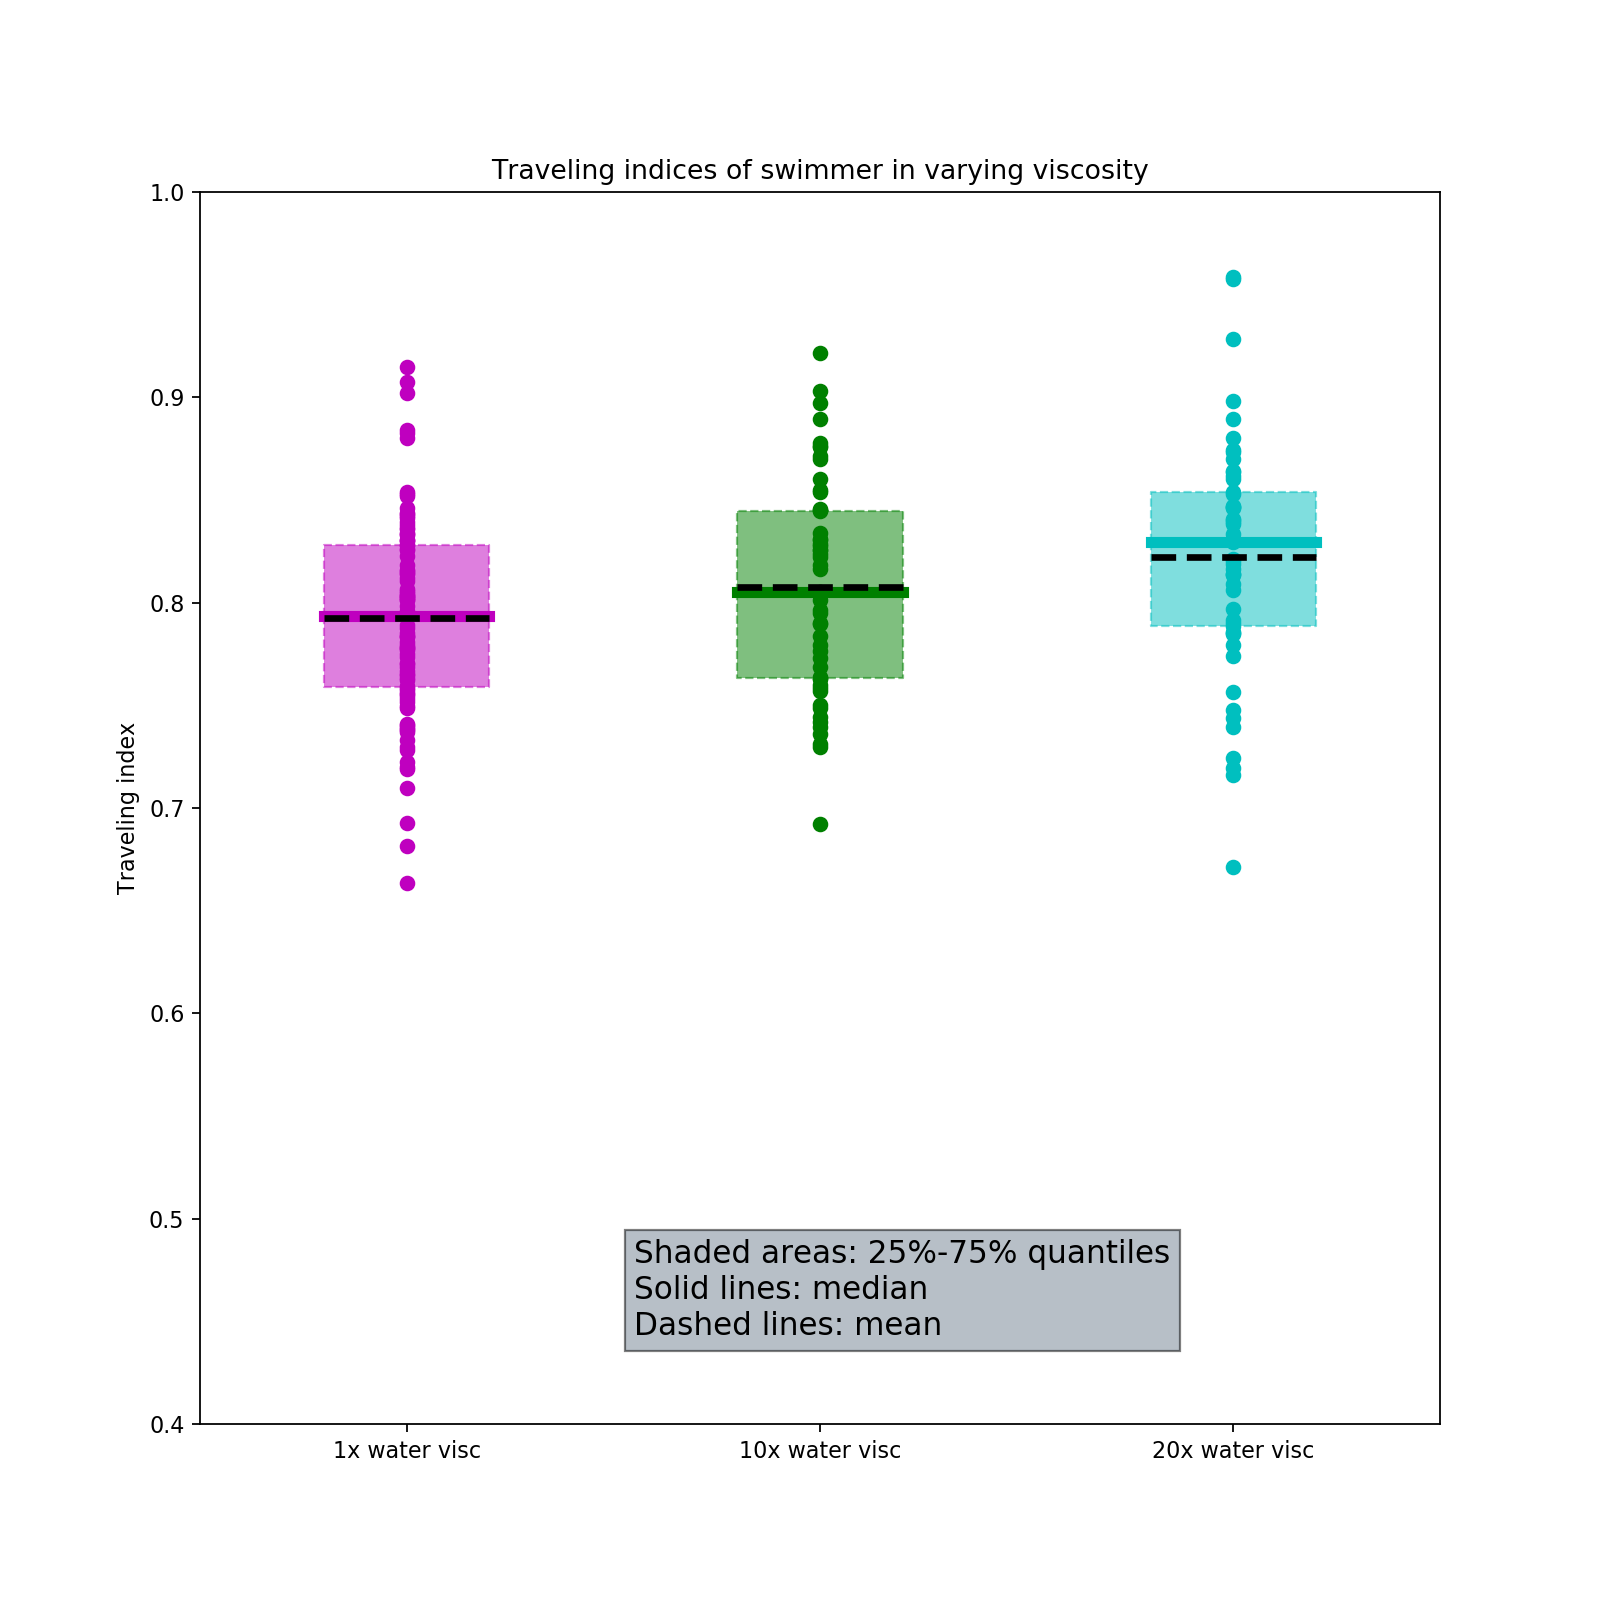

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ['m', 'g', 'c', 'k']
q1 = 0.25
q2 = 0.75
#mode = 0%8
viscosities_labels = ['1x water visc', '10x water visc', '20x water visc']
for t in range(len(viscosities)):
    ax.scatter(np.ones( traveling_indices[t].shape[0]) * t, traveling_indices[t][:, 0], c=colors[t])
    med = np.median(traveling_indices[t][:, 0])
    mean = np.mean(traveling_indices[t][:, 0])
    Q1 = np.quantile(traveling_indices[t][:, 0], q1)
    Q3 = np.quantile(traveling_indices[t][:, 0], q2)
    
    ax.plot([t-0.2, t+0.2], [med, med], color=colors[t], linestyle='-', linewidth=5)
    ax.plot([t-0.2, t+0.2], [mean, mean], color=colors[-1], linestyle='--', linewidth=3)
    ax.fill_between([t-0.2, t+0.2], [Q1, Q1], [med, med], color=colors[t], alpha=0.5, linestyle='--' )
    ax.fill_between([t-0.2, t+0.2], [Q3, Q3], [med, med], color=colors[t], alpha=0.5, linestyle='--' )

rc('axes', labelsize='large')
rc('axes', titlesize='large')
ax.set_ylabel("Traveling index");

## Here we add custom text box, since legend doesn't really do what I wanted
textstr = '\n'.join((
    'Shaded areas: {:.0f}%-{:.0f}% quantiles'.format(q1*100, q2*100),
    'Solid lines: median\nDashed lines: mean'))
props = dict(boxstyle='square', facecolor='slategrey', alpha=0.5)
ax.text(0.35, 0.15, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlim([-0.5,2.5]);
plt.ylim([0.4,1])
ax.set_xticks(np.arange(0, 3));
ax.set_xticklabels(viscosities_labels);
ax.set_title('Traveling indices of swimmer in varying viscosity');
# plt.savefig('traveling_index_v_visc')

# Fit power law to the spectra of COV, visualize with mean and standard deviation of COV

In [12]:
def power_law (x, a, b):
    return a + b*x

## Uncomment the plotting lines if you want to visualize this curve fit
# fig, ax = plt.subplots(1,3, figsize=(14, 4))
solns = np.zeros((3,2))
for i in range(3):
    
    # We fit the data by deleting the datapoints that are just numerical noise
    tmpS = average_S[i][average_S[i]>1e-13]
    tmpX = np.arange(1,len(tmpS)+1)
    opt, cov = curve_fit(power_law, np.log10(tmpX), np.log10(tmpS))
    solns[i] = opt
#     ax[i].plot(np.log10(tmpX), np.log10(tmpS), 'bo')
#     ax[i].plot(np.log10(tmpX), power_law( np.log10(tmpX), solns[i,0], solns[i,1]),\
#                label='Soln: 10^{:3.2f} * x^{:3.2f}'.format(solns[i, 0], solns[i, 1]))
#     ax[i].set_xlabel("MODE {}".format(i))
#     ax[i].legend()

<IPython.core.display.Javascript object>


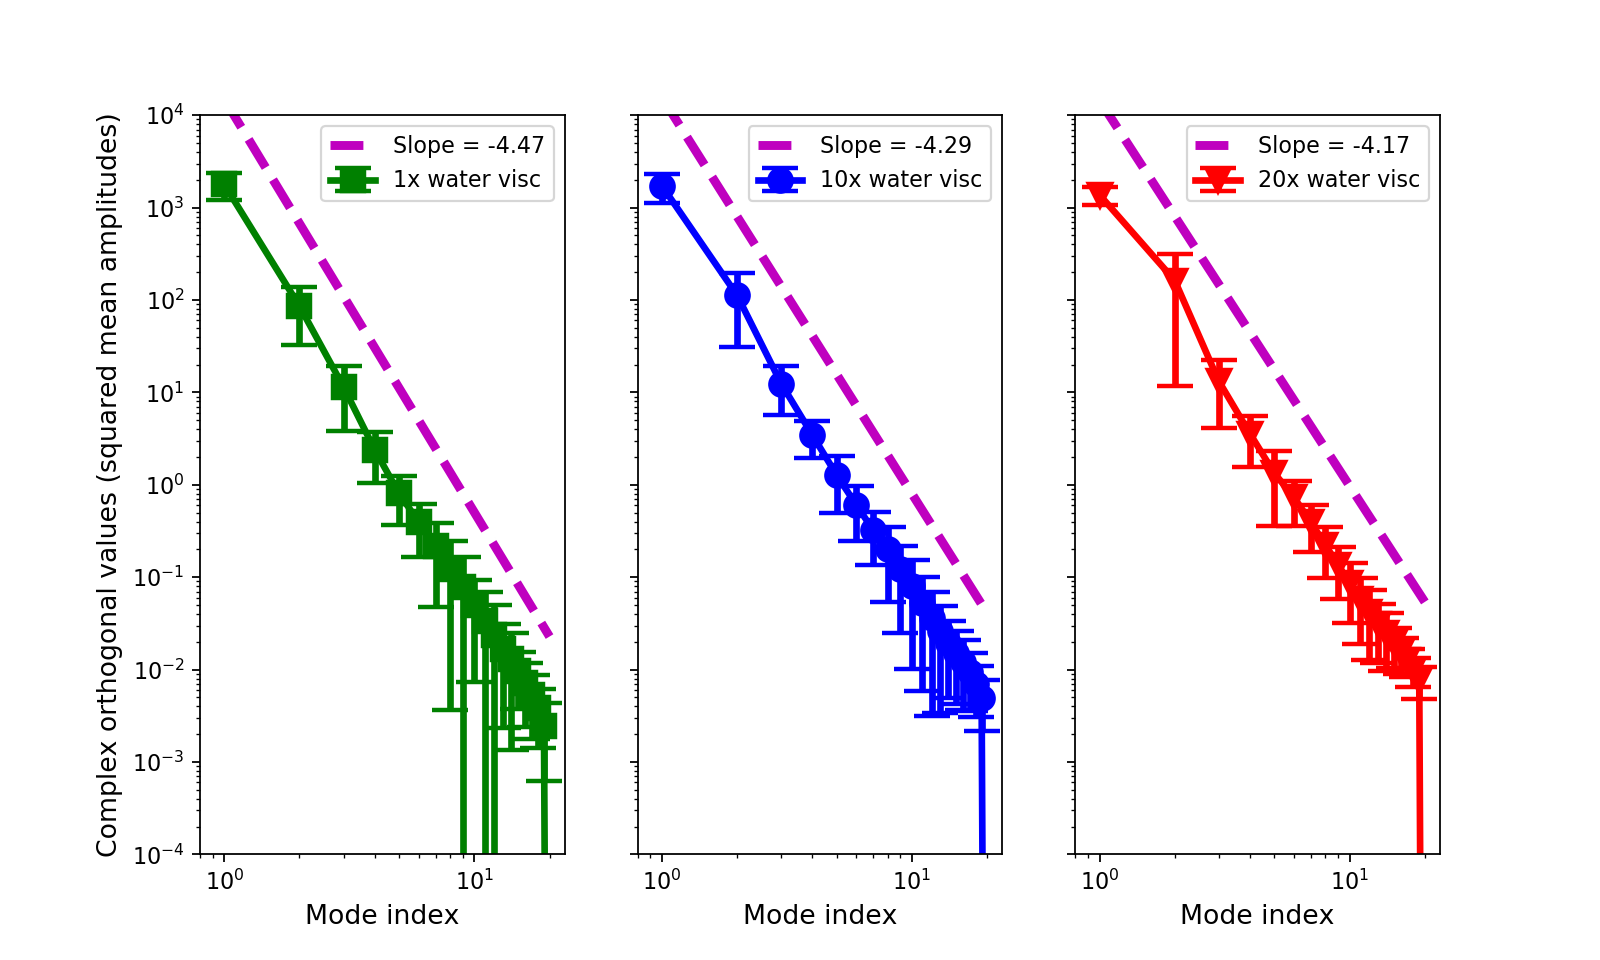

In [13]:
## Using the curve fit results above, we visualize the average COV 
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10,6))

markers = ['s', 'o', 'v']
colors = ['g', 'b', 'r']
plt.ylim([1e-4, 1e4]);
axes[0].set_ylabel("Complex orthogonal values (squared mean amplitudes)");
plt.yscale('log', nonposy='clip')

tmpX = np.arange(1,len(S)+1)

for i in range(3):
    axes[i].set_xscale('log', nonposx='clip')
    axes[i].errorbar(tmpX, average_S[i], yerr = std_S[i],
             marker=markers[i], color=colors[i], ms=10, mew=2,
             elinewidth=3, capsize=8, ecolor = colors[i],
             linewidth=3, label=viscosities_labels[i])
    axes[i].plot(tmpX, np.power(10, 1+solns[i, 0])*tmpX**(solns[i,1]), 'm--', lw=4, label='Slope = {:3.2f}'.format(solns[i, 1]))
    axes[i].set_xlabel("Mode index");
    axes[i].legend(loc='upper right')
    axes[i].set_xlim([0.8, 23])
    
# plt.savefig('Average COV vs mode index.png', format='png')